<a href="https://colab.research.google.com/github/tripatheea/auto/blob/main/spectrogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install tensorflow-probability

# to generate gifs
! pip install imageio
! pip install git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-8zw8v3zt
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-8zw8v3zt


In [2]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

from tensorflow.python.framework.ops import disable_eager_execution

In [3]:
# import keras
# from keras import Model
# from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Reshape, Dense, Lambda, Flatten
# from keras import backend as K

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import glob
import skimage
import skimage.transform
import skimage.io
import PIL
import numpy as np
import os
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import imageio
# import utils

In [4]:
disable_eager_execution()

In [5]:
WIDTH = 48

In [180]:
import numpy as np
import matplotlib.pyplot as plt

def	MakeSpectrogram(f_sig = 100., bandwidth = 0.25, Tobs_hr = 24., Tcoh_hr = .25, 
		hnoise = 100., hamp = .4, fsamp = 512., fdot_sig = -1e-6, 
		plot_num = 0, plot = False, write_to_file = False):
	
	##### Defining Variables #####
	# f_sig     --- signal central frequency, hz
	# bandwidth --- bandwidth of search, width of each freq, hz
	# Tobs_hr   --- Length of observation, hrs
	# Tcoh_hr   --- Coherence time, hrs
	# hnoise    --- noise amplitude
	# hamp      --- signal amplitude
	# fsamp     --- sampling frequency, hz
	# fdot_sig  --- Signal frequency derivative 
	# plot_num  --- if multiple files is an index
	# whereto   --- Where to save plot
	
	##### Booleans ####
	# plot      	--- whether or not to plot
	# write_to_file --- whether to save data to .txt file

	#### Returns ####
	# frequency 
	# time
	# spectrogram

	# Define constants
	SECS_PER_HOUR = 3600
	
	# Find amplitude spectral density for noise
	noiseamp = hnoise*np.sqrt(4./fsamp) 
	
	
	# Convert observation and coherence time to seconds
	Tobs = Tobs_hr * SECS_PER_HOUR
	Tcoh = Tcoh_hr * SECS_PER_HOUR

	# Find low and high frequency
	freqlo_approx = f_sig - 0.5 * bandwidth
	freqlo = np.floor(freqlo_approx * Tcoh) / Tcoh
	freqhi = freqlo + bandwidth

	# Define time series to hold raw data stream of signal + noise
	deltat = 1. / fsamp
	t = np.arange(0,Tobs,deltat)
	Nsample = len(t)
	print ('Nsample = %i'%len(t))
	
	# Generate signal in the time domain
	noise = noiseamp * np.random.normal(0, scale = 1, size = (Nsample,))
	signal = hamp * np.sin(2 * np.pi * (f_sig * t + .5 * fdot_sig * t**2))

	data = signal + noise

	# Generate spectra for each coherence time & extract band of interest to make spectrogram
	indbandlo = int(np.floor(freqlo * Tcoh))
	indbandhi = int(np.floor(freqhi * Tcoh))
	nbandbin  = indbandhi - indbandlo
	Nseg = int(np.floor(Tobs / Tcoh))
	Nsample_coh = int(np.floor(Nsample / Nseg))
	spectrogram = np.zeros((nbandbin,Nseg),)	
	print( np.shape(spectrogram) )
	
	for seg in range(Nseg):
		# print('Generating segment %d\n'%(seg))
		indlo = seg * Nsample_coh
		indhi = indlo + Nsample_coh 
		segment = data[indlo:indhi]
		
		rawfft = np.fft.fft(segment,Nsample_coh, axis = 0)
		spectrogram[:,seg] = 2 * abs(rawfft[indbandlo:indbandhi])
		
	segarray = np.arange(0,Nseg)
	seghour = (segarray) * Tcoh / SECS_PER_HOUR
	indarray = np.arange(indbandlo,indbandhi + 1)
	freqplot = (indarray - indbandlo)*1.0/Tcoh + freqlo	
	
	if plot:
		plt.clf()
		print('Plotting spectrogram')
		
		plt.pcolormesh(seghour, freqplot, spectrogram)
		plt.ylabel('Frequency [Hz]')
		plt.xlabel('Time [Hours]')
  
  
	return(seghour, freqplot, spectrogram)



In [7]:
def define_encoder_block(x, num_filters):  
    """
    Todo: Define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
          Also define a 2D max pooling layer (MaxPooling2D) (you can keep default arguments).
    """
    x = tf.keras.layers.Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    return x

In [8]:
def define_decoder_block(x, num_filters):
    """
    Todo: Define one 2D upsampling layer (UpSampling2D) (you can keep default arguments).
          Also, define two sequential 2D convolutional layers (Conv2D) with the following properties:
          - num_filters many filters
          - kernel_size 3
          - activation "relu"
          - padding "same"
          - kernel_initializer "he_normal"
    """
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, activation='relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    return x

In [9]:
def define_net(variational, height, width, batch_size, latent_dim, conditioning_dim=0,
               start_filters=8):
    """Defines a (variational) encoder-decoder architecture.
    , in train_function  *
        return step_function(self, iterator)
    Args:
        variational: Whether a variational autoencoder should be defined.
        height: The height of the image input and output.
        width: The width of the image input and output.
        batch_size: The batchsize that is used during training. Must also be used for inference on the encoder side.
        latent_dim: The dimension of the latent space.
        conditioning_dim: The dimension of the space of variables to condition on. Can be zero for an unconditional VAE.
        start_filters: The number of filters to start from. Multiples of this value are used across the network. Can be used
            to change model capacity.
        
    Returns:
        Tuple of keras models for full VAE, encoder part and decoder part only.
    """
    
    # Prepare the inputs.
    inputs = tf.keras.layers.Input((height, width, 1))
    # inputs = Input((height, width))
    if conditioning_dim > 0:
        # Define conditional VAE. Note that this is usually not the preferred way
        # of incorporating the conditioning information in the encoder.
        condition = tf.keras.layers.Input([conditioning_dim])
        condition_up = tf.keras.layers.Dense(height * width)(condition)
        condition_up = tf.keras.layers.Reshape([height, width, 1])(condition_up)
        inputs_new = tf.keras.layers.Concatenate(axis=3)([inputs, condition_up])
    else:
        inputs_new = inputs
    
    # Define the encoder.
    eblock1 = define_encoder_block(inputs_new, start_filters)
    eblock2 = define_encoder_block(eblock1, start_filters*2)
    eblock3 = define_encoder_block(eblock2, start_filters*4)
    eblock4 = define_encoder_block(eblock3, start_filters*8)
    _, *shape_spatial = eblock4.get_shape().as_list()
    eblock4_flat = tf.keras.layers.Flatten()(eblock4)
    
    if not variational:
        z = tf.keras.layers.Dense(latent_dim)(eblock4_flat)
    else:
        # Perform the sampling.
        def sampling(args):
            """Samples latent variable from a normal distribution using the given parameters."""
            z_mean, z_log_sigma = args
            return z_mean
            # epsilon = tf.random.normal(shape=(batch_size, latent_dim), mean=0., stddev=1.)
            # return z_mean + tf.math.exp(z_log_sigma) * epsilon
        
        z_mean = tf.keras.layers.Dense(latent_dim)(eblock4_flat)
        z_log_sigma = tf.keras.layers.Dense(latent_dim)(eblock4_flat)
        z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])
    
    if conditioning_dim > 0:
        z_ext = tf.keras.layers.Concatenate()([z, condition])

    print(shape_spatial)
    # Define the decoder.
    inputs_embedding = tf.keras.layers.Input([latent_dim + conditioning_dim])                       # 2
    embedding = tf.keras.layers.Dense(np.prod(shape_spatial), activation='relu')(inputs_embedding)  # 
    embedding = tf.keras.layers.Reshape(eblock4.shape.as_list()[1:])(embedding)                     # (None, 1, , 64)
    
    print("embeding", embedding.shape)          
    dblock1 = define_decoder_block(embedding, start_filters*2)      # (None, 2, 2, 24)
    print("dblock1", dblock1.shape)
    dblock2 = define_decoder_block(dblock1, start_filters*4)        # (None, 4, 4, 32)
    print("dblock2", dblock2.shape)
    dblock3 = define_decoder_block(dblock2, start_filters*8)        # (None, 8, 8, 24)
    print("dblock3", dblock3.shape)
    dblock4 = define_decoder_block(dblock3, start_filters)          # (None, 16, 16, 8)
    print("dblock4", dblock4.shape)
    output = tf.keras.layers.Conv2D(1, 1, activation = 'tanh')(dblock4)             # (8, 32, 48, 3)
    # output = Conv2D(1, 1, activation = 'tanh')(dblock4)

    # 1, 1, 64; 2, 2, 24; 4, 4, 32; 8, 8, 24; 16, 16, 8
    
    print("hey")
    # Define the models.
    decoder = tf.keras.Model(inputs = inputs_embedding, outputs = output)
    if conditioning_dim > 0:
        encoder_with_sampling = tf.keras.Model(inputs = [inputs, condition], outputs = z)
        encoder_with_sampling_ext = tf.keras.Model(inputs = [inputs, condition], outputs = z_ext)
        vae_out = decoder(encoder_with_sampling_ext([inputs, condition]))
        vae = tf.keras.Model(inputs = [inputs, condition], outputs = vae_out)
    else:
        encoder_with_sampling = tf.keras.Model(inputs = inputs, outputs = z)
        vae_out = decoder(encoder_with_sampling(inputs))
        vae = tf.keras.Model(inputs = inputs, outputs = vae_out)
    print(vae.summary())
    # Define the VAE loss.
    def vae_loss(x, x_decoded_mean):
        """Defines the VAE loss functions as a combination of MSE and KL-divergence loss."""

        # print(x.shape, x_decoded_mean.shape)
        mse_loss = tf.math.reduce_mean(tf.keras.losses.mse(x, x_decoded_mean), axis=(1, 2)) * height * width
        kl_loss = - 0.5 * tf.math.reduce_mean(1 + z_log_sigma - tf.math.square(z_mean) - tf.math.exp(z_log_sigma), axis=-1)
        # kl_loss = - 0.5 * tf.math.reduce_mean(z_log_sigma, axis=-1)

        # print(kl_loss)
        # return mse_loss + kl_loss
        # return -1.56
        # return np.random.random()
        return mse_loss + kl_loss
    
    if variational:
        vae.compile(loss=vae_loss, optimizer='adam', experimental_run_tf_function=False)
    else:
        vae.compile(loss='mse', optimizer='adam', experimental_run_tf_function=False)    
        
    print('done,', vae.count_params(), 'parameters.')
    return vae, encoder_with_sampling, decoder

In [10]:
def encode_image(img, conditioning, encoder, height, width, batch_size):
    '''Encodes an image that is given in RGB-channel order with value range of [0, 255].
    
    Args:
        img: The image input. If shapes differ from (height, width), it will be resized.
        conditoning: The set of values to condition on, if any. Can be None.
        encoder: The keras encoder model to use.
        height: The target image height.
        width: The target image width.
        batch_size: The batchsize that the encoder expects.
        
    Returns:
        The latent representation of the input image.
    '''
    if img.shape[0] != height or img.shape[1] != width:
        img = skimage.transform.resize(img, (height, width))
    img_single = np.expand_dims(img, axis=0)
    img_single = img_single.astype(np.float32)
    img_single = np.repeat(img_single, batch_size, axis=0)
    if conditioning is None:
        z = encoder.predict(img_single)
    else:
        z = encoder.predict([img_single, np.repeat(np.expand_dims(conditioning, axis=0), batch_size, axis=0)])
    return z

In [11]:
def decode_embedding(z, conditioning, decoder):
    '''Decodes the given representation into an image.
    
    Args:
        z: The latent representation.
        conditioning: The set of values to condition on, if any. Can be None.
        decoder: The keras decoder model to use.
    '''
    if z.ndim < 2:
        z = np.expand_dims(z, axis=0) # Single-batch
    if conditioning is not None:
        z = np.concatenate((z, np.repeat(np.expand_dims(conditioning, axis=0), z.shape[0], axis=0)), axis=1)
    return decoder.predict(z)

In [12]:
def load_weights(folder):
    vae.load_weights(folder + '/vae.w')
    encoder.load_weights(folder + '/encoder.w')
    decoder.load_weights(folder + '/decoder.w')
    
def save_weights(folder):
    if not os.path.isdir(folder):
        os.mkdir(folder)
    vae.save_weights(folder + '/vae.w')
    encoder.save_weights(folder + '/encoder.w')
    decoder.save_weights(folder + '/decoder.w')

In [13]:
def fix_dims_and_normalize(s):
  
  s = np.pad(s, ((0, WIDTH - s.shape[0]), (0, WIDTH - s.shape[1])))

  return s / np.max(s)

In [123]:
bandwidth = 0.05
f_sig = 20.0

Nsample = 5529600
(45, 48)
Plotting spectrogram


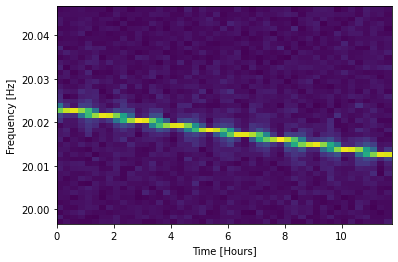

In [172]:
t, f, spec = MakeSpectrogram(f_sig = np.random.uniform(f_sig - 0.5 * bandwidth, f_sig + 0.5 * bandwidth), bandwidth = bandwidth, Tobs_hr = 12., Tcoh_hr = .25, 
              hnoise = np.random.uniform(0.0, 0.2), hamp = np.random.uniform(0.001, 0.005), fsamp = 128., fdot_sig = np.random.choice([-1, 1]) * 10**np.random.uniform(-5, -7), 
              plot_num = 0, plot = True, write_to_file = False)

In [173]:
f_sig - 0.5 * bandwidth, f_sig + 0.5 * bandwidth

(19.975, 20.025)

In [174]:
np.random.uniform(f_sig - 0.5 * bandwidth, f_sig + 0.5 * bandwidth)

19.996485872471965

Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spectrogram
Nsample = 5529600
(45, 48)
Plotting spec

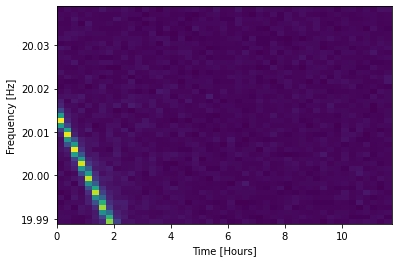

In [191]:
all_specs = []
N = 25
for i in range(N):
  # t, f, spec = MakeSpectrogram(f_sig = np.random.random() * 100., bandwidth = 0.05, Tobs_hr = 12., Tcoh_hr = .25, 
  #             hnoise = 100. + (1 - 2 * np.random.random() * 10.), hamp = .4, fsamp = 128., fdot_sig = -1e-6, 
  #             plot_num = 0, plot = True, write_to_file = False)
  t, f, spec = MakeSpectrogram(f_sig = np.random.uniform(f_sig - 0.5 * bandwidth, f_sig + 0.5 * bandwidth), bandwidth = bandwidth, Tobs_hr = 12., Tcoh_hr = .25, 
            hnoise = np.random.uniform(0.0, 0.2), hamp = np.random.uniform(0.001, 0.005), fsamp = 128., fdot_sig = np.random.choice([-1, 1]) * 10**np.random.uniform(-5, -7), 
            plot_num = 0, plot = True, write_to_file = False)
  
  r = fix_dims_and_normalize(np.copy(spec))

  # print(r.shape)
  all_specs.append(r)

all_specs = np.asanyarray(all_specs)

size = len(all_specs)

print(all_specs.shape)

In [192]:
x_train = all_specs[np.random.choice(list(range(all_specs.shape[0])), size=int(0.8 * size), replace=False)]
x_test = all_specs[np.random.choice(list(range(all_specs.shape[0])), size=int(0.2 * size), replace=False)]

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [193]:
x_train.shape, x_test.shape

((20, 48, 48, 1), (5, 48, 48, 1))

(48, 48)

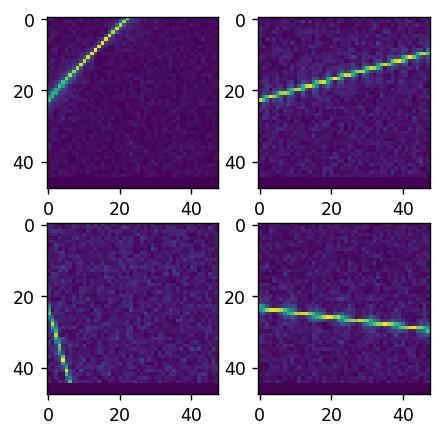

In [198]:

plt.figure(figsize=(4, 4), dpi=125)


for i in range(1, 5):
  plt.subplot(2, 2, i)
  plt.imshow(x_train[i - 1,:,:,0])

x_train[0,:,:,0].shape

(48, 48)

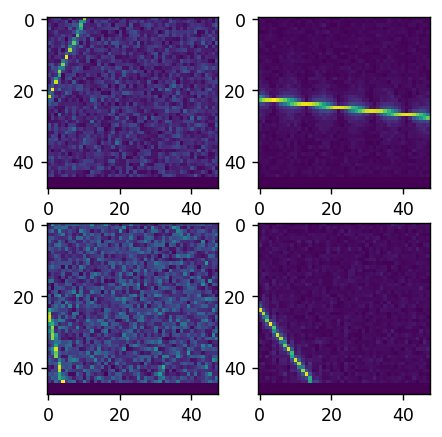

In [201]:
plt.figure(figsize=(4, 4), dpi=125)

for i in range(1, 5):
  plt.subplot(2, 2, i)
  plt.imshow(x_test[i - 1,:,:,0])

x_test[0,:,:,0].shape

In [202]:
vae, encoder, decoder = define_net(True, 48, 48, batch_size=4, latent_dim=1, start_filters=8)

[3, 3, 64]
embeding (None, 3, 3, 64)
dblock1 (None, 6, 6, 16)
dblock2 (None, 12, 12, 32)
dblock3 (None, 24, 24, 64)
dblock4 (None, 48, 48, 8)
hey
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 model_7 (Functional)        (None, 1)                 74618     
                                                                 
 model_6 (Functional)        (None, 48, 48, 1)         87225     
                                                                 
Total params: 161,843
Trainable params: 161,843
Non-trainable params: 0
_________________________________________________________________
None
done, 161843 parameters.


In [203]:
vae.fit(x_train, x_train, batch_size=4, verbose=1, epochs=50)

Train on 20 samples
Epoch 1/50
20/20 [==============================] - 1s 46ms/sample - loss: 50.0788
Epoch 2/50
20/20 [==============================] - 0s 17ms/sample - loss: 35.5681
Epoch 3/50
20/20 [==============================] - 0s 17ms/sample - loss: 32.0225
Epoch 4/50
20/20 [==============================] - 0s 17ms/sample - loss: 28.8470
Epoch 5/50
20/20 [==============================] - 0s 16ms/sample - loss: 28.1969
Epoch 6/50
20/20 [==============================] - 0s 17ms/sample - loss: 27.9310
Epoch 7/50
20/20 [==============================] - 0s 17ms/sample - loss: 27.4187
Epoch 8/50
20/20 [==============================] - 0s 17ms/sample - loss: 26.9725
Epoch 9/50
20/20 [==============================] - 0s 18ms/sample - loss: 26.1772
Epoch 10/50
20/20 [==============================] - 0s 17ms/sample - loss: 25.7884
Epoch 11/50
20/20 [==============================] - 0s 17ms/sample - loss: 24.8262
Epoch 12/50
20/20 [==============================] - 0s 16ms/samp

In [204]:
x_train.shape, x_train[0,:,:].shape, np.expand_dims(x_train[0,:,:], axis=0).shape

((20, 48, 48, 1), (48, 48, 1), (1, 48, 48, 1))

In [205]:
x_train_encoded = encoder.predict(np.expand_dims(x_train[0,:,:], axis=0), batch_size=1)

x_train_encoded.shape

(1, 1)

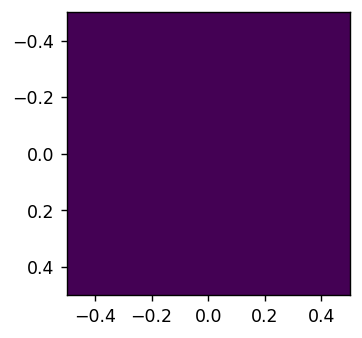

In [206]:
plt.figure(figsize=(5, 3), dpi=125)

plt.imshow(x_train_encoded)

In [207]:
# decoder.

In [226]:
x_demo = x_test[np.random.randint(x_test.shape[0])]
pred = vae.predict(np.expand_dims(x_demo, axis=0))
# plt.imshow(x_demo)
# plt.show()
# plt.imshow(pred[0])

x_demo.shape, np.expand_dims(x_demo, axis=0).shape, pred.shape

((48, 48, 1), (1, 48, 48, 1), (1, 48, 48, 1))

In [229]:
pred.shape

(1, 48, 48, 1)

Text(0.5, 1.0, 'Reconstruction')

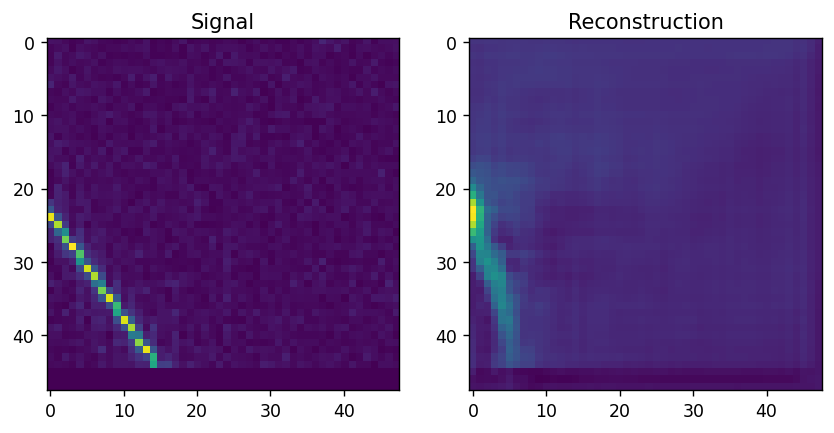

In [230]:
plt.figure(figsize=(8, 5), dpi=125)

plt.subplot(121)
plt.imshow(x_demo[:,:,0])
plt.title("Signal")

plt.subplot(122)
plt.imshow(pred[0,:,:,0])
plt.title("Reconstruction")

In [231]:
x_demo_train = x_train[np.random.randint(x_test.shape[0])]
pred_train = vae.predict(np.expand_dims(x_demo_train, axis=0))

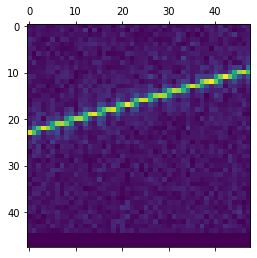

In [232]:
plt.matshow(x_demo_train[:,:,0])

Text(0.5, 1.0, 'Reconstruction')

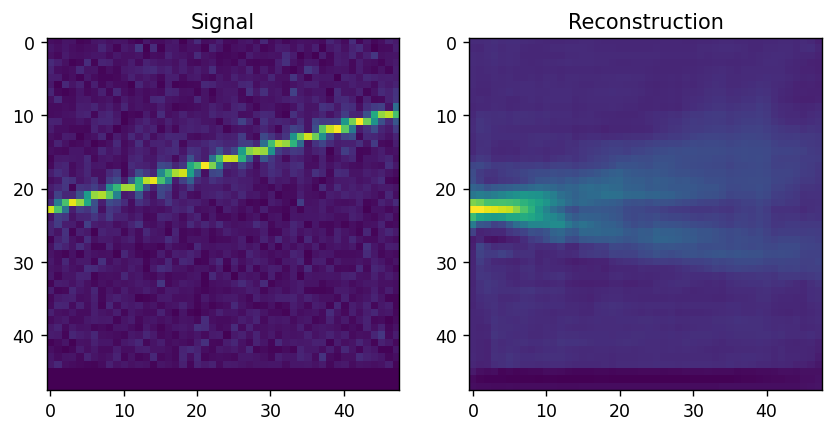

In [236]:
plt.figure(figsize=(8, 5), dpi=125)

plt.subplot(121)
plt.imshow(x_demo_train[:,:,0])
plt.title("Signal")

plt.subplot(122)
plt.imshow(pred_train[0,:,:,0])
plt.title("Reconstruction")

In [ ]:
x_test_encoded = encoder.predict(x_test, batch_size=8)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], cmap='tab10')
plt.colorbar()
plt.show()

InvalidArgumentError: ignored